In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision.utils import make_grid
import random

In [2]:
# Updated Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop to 224x224 pixels
        transforms.RandomHorizontalFlip(),  # Randomly flip the image vertically
        transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),  # Resize to 224x224 pixels
        transforms.CenterCrop(224),  # Center crop to 224x224 pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),  # Resize to 224x224 pixels
        transforms.CenterCrop(224),  # Center crop to 224x224 pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'D:\Splitted Curated X-Ray Dataset'

In [3]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']


In [4]:
# Define the path to the train and val folders
train_folder = os.path.join(data_dir, 'train')
val_folder = os.path.join(data_dir, 'val')
test_folder = os.path.join(data_dir, 'test')

# Function to count the number of images in each class folder
def count_images_per_class(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_count = len(os.listdir(class_path))
            class_counts[class_name] = class_count
    return class_counts

# Print dataset sizes for each class in the training dataset
print("--Training Dataset--")
train_class_counts = count_images_per_class(train_folder)
for class_name, count in train_class_counts.items():
    print(f"{class_name} : {count}")

# Print dataset sizes for each class in the validation dataset
print("\n--Validation Dataset--")
val_class_counts = count_images_per_class(val_folder)
for class_name, count in val_class_counts.items():
    print(f"{class_name} : {count}")

# Print dataset sizes for each class in the test dataset
print("\n--Test Dataset--")
val_class_counts = count_images_per_class(test_folder)
for class_name, count in val_class_counts.items():
    print(f"{class_name} : {count}")

--Training Dataset--
COVID-19 : 1024
Normal : 2616
Pneumonia-Bacterial : 2400
Pneumonia-Viral : 1324

--Validation Dataset--
COVID-19 : 128
Normal : 327
Pneumonia-Bacterial : 300
Pneumonia-Viral : 165

--Test Dataset--
COVID-19 : 129
Normal : 327
Pneumonia-Bacterial : 301
Pneumonia-Viral : 167


In [5]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA (GPU) is available.")
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f"Current GPU: {current_gpu}")
else:
    print("CUDA (GPU) is not available. Using CPU.")


CUDA (GPU) is available.
Number of GPUs available: 1
Current GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [6]:
# def imshow(inp, title=None):
#     """Display image for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


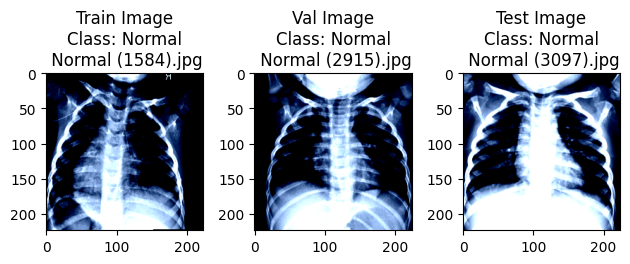

In [7]:
# Randomly select an image from the train dataset
random_train_idx = random.randint(0, len(image_datasets['train']) - 1)
random_train_image, random_train_label = image_datasets['train'][random_train_idx]
random_train_class = class_names[random_train_label]
random_train_image_name = image_datasets['train'].imgs[random_train_idx][0].split("\\")[-1]

# Randomly select an image from the val dataset
random_val_idx = random.randint(0, len(image_datasets['val']) - 1)
random_val_image, random_val_label = image_datasets['val'][random_val_idx]
random_val_class = class_names[random_val_label]
random_val_image_name = image_datasets['val'].imgs[random_val_idx][0].split("\\")[-1]

# Randomly select an image from the test dataset
random_test_idx = random.randint(0, len(image_datasets['test']) - 1)
random_test_image, random_test_label = image_datasets['test'][random_test_idx]
random_test_class = class_names[random_test_label]
random_test_image_name = image_datasets['test'].imgs[random_test_idx][0].split("\\")[-1]

# Convert tensors to numpy arrays for visualization
random_train_image = random_train_image.numpy().transpose((1, 2, 0))
random_val_image = random_val_image.numpy().transpose((1, 2, 0))
random_test_image = random_test_image.numpy().transpose((1, 2, 0))

# Display the train image
plt.subplot(1, 3, 1)
plt.imshow(random_train_image)
plt.title(f"Train Image\nClass: {random_train_class}\n {random_train_image_name}")

# Display the val image
plt.subplot(1, 3, 2)
plt.imshow(random_val_image)
plt.title(f"Val Image\nClass: {random_val_class}\n {random_val_image_name}")


# Display the val image
plt.subplot(1, 3, 3)
plt.imshow(random_test_image)
plt.title(f"Test Image\nClass: {random_test_class}\n {random_test_image_name}")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [8]:
model_ft = models.resnet50(weights='IMAGENET1K_V2')
num_classes = 4

model_ft.fc = nn.Conv2d(2048, num_classes, kernel_size=1)
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
model_ft.fc = nn.Linear(2048, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

from torchsummary import summary
summary(model_ft,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5492 Acc: 0.7731
val Loss: 0.6347 Acc: 0.7609

Epoch 1/24
----------
train Loss: 0.4442 Acc: 0.8133
val Loss: 0.8923 Acc: 0.6772

Epoch 2/24
----------
train Loss: 0.4225 Acc: 0.8248
val Loss: 0.4368 Acc: 0.8120

Epoch 3/24
----------
train Loss: 0.3944 Acc: 0.8364
val Loss: 0.6296 Acc: 0.7750

Epoch 4/24
----------
train Loss: 0.3779 Acc: 0.8365
val Loss: 0.3819 Acc: 0.8391

Epoch 5/24
----------
train Loss: 0.3590 Acc: 0.8495
val Loss: 0.4657 Acc: 0.8130

Epoch 6/24
----------
train Loss: 0.3595 Acc: 0.8487
val Loss: 0.5282 Acc: 0.8076

Epoch 7/24
----------
train Loss: 0.2976 Acc: 0.8729
val Loss: 0.3516 Acc: 0.8543

Epoch 8/24
----------
train Loss: 0.2793 Acc: 0.8809
val Loss: 0.3608 Acc: 0.8511

Epoch 9/24
----------
train Loss: 0.2657 Acc: 0.8851
val Loss: 0.3697 Acc: 0.8424

Epoch 10/24
----------
train Loss: 0.2589 Acc: 0.8869
val Loss: 0.3554 Acc: 0.8478

Epoch 11/24
----------
train Loss: 0.2550 Acc: 0.8907
val Loss: 0.3455 Acc: 0.8630

Ep

In [11]:
torch.save(model_ft, 'D:/UNAIR/SKRIPSI/Seminar Proposal/FIX/Kodingan/Saved Model/Resnet_with_Aug.pth') # Save The Model
# model_ft = models.googlenet # Load Model
# model_ft.load_state_dict(torch.load('D:/UNAIR/SKRIPSI/Seminar Proposal/FIX/Kodingan/Saved Model/Resnet_No_Aug.pth')) # Load Model
# model_ft.eval() # Load Model
# print(model_ft)

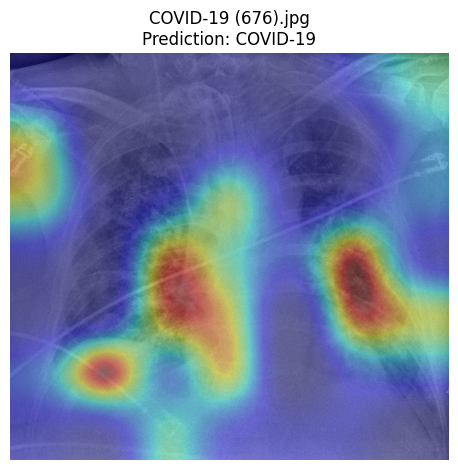

In [32]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

def viz_cam():

    # Define your model (Assuming 'model_ft' is defined somewhere in your code)
    model = model_ft.eval()

    # Set your CAM extractor
    from torchcam.methods import CAM
    cam_extractor = CAM(model,'layer4','fc')

    # Select a random image from the specified dataset
    random_image_index = random.randint(0, len(image_datasets['test']) - 1)
    img_path = image_datasets['test'].imgs[random_image_index][0]
    img_name = image_datasets['test'].imgs[random_image_index][0].split("\\")[-1]

    img = read_image(img_path)
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Move the input tensor to the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)

    with CAM(model) as cam_extractor:
        # Preprocess your data and feed it to the model
        out = model(input_tensor.unsqueeze(0))
        # Get the predicted class index
        predicted_class_index = out.squeeze(0).argmax().item()
        # Retrieve the CAM by passing the class index and the model output
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    predicted_class = class_names[predicted_class_index]

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.6)

    # Display it with title and prediction
    plt.imshow(result)
    plt.title(f"{img_name}\nPrediction: {predicted_class}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

viz_cam()

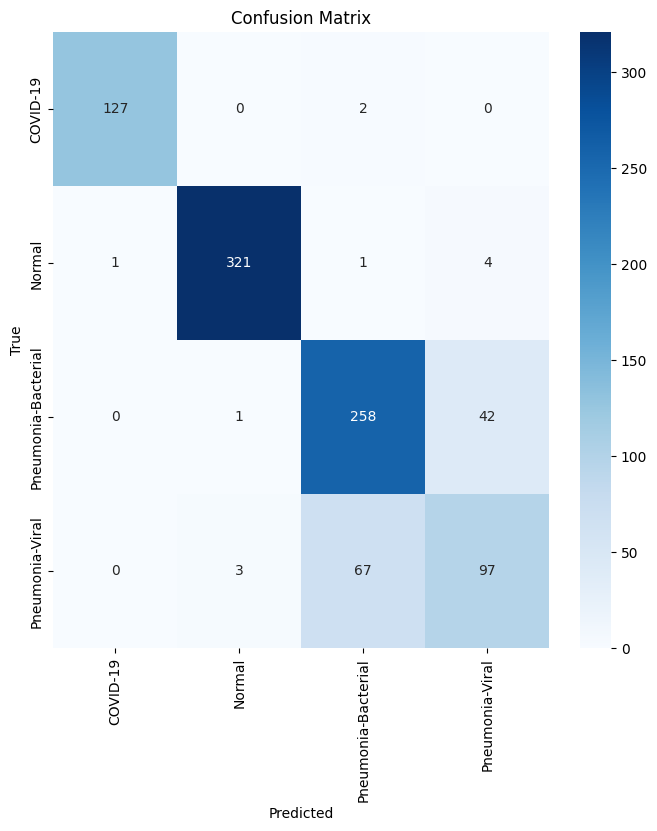

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(model, dataloader, device):
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Create the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    return conf_matrix

# Assuming 'model_ft' is already defined and loaded with the appropriate weights
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conf_matrix = generate_confusion_matrix(model_ft, dataloaders['test'], device)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
from sklearn.metrics import classification_report
# Evaluate on the test set using the best model
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate and print the classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("Classification Report:\n", report)

Classification Report:
                      precision    recall  f1-score   support

           COVID-19     0.9922    0.9845    0.9883       129
             Normal     0.9877    0.9817    0.9847       327
Pneumonia-Bacterial     0.7866    0.8571    0.8203       301
    Pneumonia-Viral     0.6783    0.5808    0.6258       167

           accuracy                         0.8690       924
          macro avg     0.8612    0.8510    0.8548       924
       weighted avg     0.8669    0.8690    0.8668       924



In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def evaluate_auc_roc(model, dataloader, num_classes, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_preds[:, i])
        roc_auc[i] = roc_auc_score(all_labels == i, all_preds[:, i])

 # Plot ROC curve
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('AUC-ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()


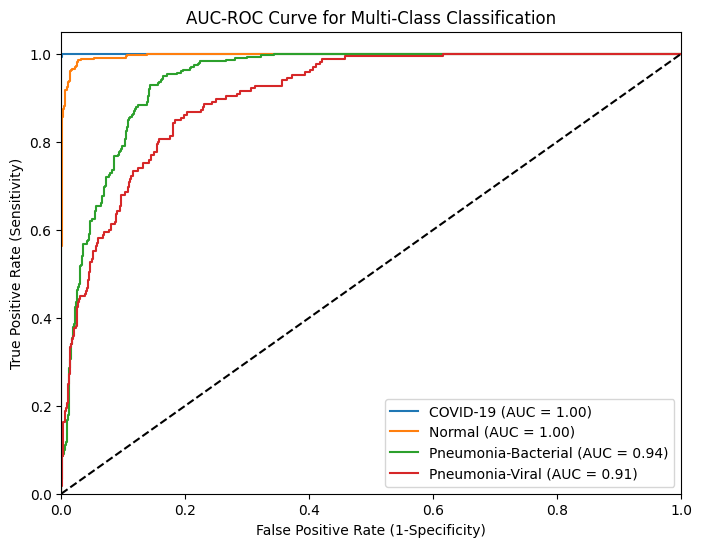

In [16]:
model_ft.eval()
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
evaluate_auc_roc(model_ft, dataloaders['val'], num_classes, class_names)

In [17]:
# import matplotlib.pyplot as plt

# # Visualize the raw CAM
# plt.imshow(activation_map[0].squeeze(0).cpu().numpy())
# plt.axis('off')
# plt.tight_layout()
# plt.show()
